# Sentiment Analysis of Real Time Twitter Data

#### After saving the data in the s3 bucket we will retrive the data and perform exploratory data analysis and sentiment analysis on the real time twitter data.

In [1]:
#Importing required libraries
import os
import tweepy as tw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import re
import networkx as nx
import boto3         
import botocore
import pickle
import string
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [2]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

#### Importing data from aws s3 bucket

In [3]:
# Create an S3 client
S3 = boto3.client('s3')
BUCKET_NAME = 'twitter-analytics-bot'

In [4]:
#Retrieving the object stored in s3 bucket
#Read the object stored in key 'myList001'
object = S3.get_object(Bucket=BUCKET_NAME,Key='myList001')
serializedObject = object['Body'].read()
#Deserialize the retrieved object
myList = pickle.loads(serializedObject)

In [5]:
len(myList)

5616

In [6]:
all_tweets = myList

In [7]:
with open('tweet.txt', 'w') as f:
    for item in all_tweets:
        f.write("    %s\n" % item.encode('utf-8'))

## Text Preprocessing
#### There are some steps required to make a tweet ready for sentiment analysis.
1.) Remove unicode strings and noise.<br>
2.) Replace URL, user mention and hashtags. <br>
3.) Remove Numbers. <br>
4.) Replace Repetitions of Punctuation. <br>
5.) Remove Contractions. <br>
6.) Handling Capitalized Words. <br>
7.) Lowercase. <br>
8.) Lemmatizing. <br>
9.) Stemming. <br>

In [8]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)                       
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

In [9]:
def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

def countMultiExclamationMarks(text):
    """ Replaces repetitions of exlamation marks """
    return len(re.findall(r"(\!)\1+", text))

def countMultiQuestionMarks(text):
    """ Count repetitions of question marks """
    return len(re.findall(r"(\?)\1+", text))

def countMultiStopMarks(text):
    """ Count repetitions of stop marks """
    return len(re.findall(r"(\.)\1+", text))

def countAllCaps(text):
    """ Input: a text, Output: how many words are all caps """
    return len(re.findall("[A-Z0-9]{3,}", text))

In [10]:
""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def addCapTag(word):
    """ Finds a word with at least 3 characters capitalized and adds the tag ALL_CAPS_ """
    if(len(re.findall("[A-Z]{3,}", word))):
        word = word.replace('\\', '' )
        transformed = re.sub("[A-Z]{3,}", "ALL_CAPS_"+word, word)
        return transformed
    else:
        return word
    
def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def countEmoticons(text):
    """ Input: a text, Output: how many emoticons """
    return len(re.findall(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', text))

In [11]:
finalTokens = [] # all tokens
stoplist = stopwords.words('english')
my_stopwords = "multiexclamation multiquestion multistop url atuser st rd nd th am pm" # my extra stopwords
stoplist = stoplist + my_stopwords.split()

In [12]:
lemmatizer = WordNetLemmatizer() # set lemmatizer
stemmer = PorterStemmer() # set stemmer

In [13]:
def tokenize(text, wordCountBefore):
    totalAdjectives = 0
    totalAdverbs = 0
    totalVerbs = 0
    onlyOneSentenceTokens = [] # tokens of one sentence each time

    tokens = nltk.word_tokenize(text)
        
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator) # Technique: remove punctuation

    tokens = nltk.word_tokenize(text) # it takes a text as an input and provides a list of every token in it
    
    for w in tokens:

        if (w not in stoplist): # Technique: remove stopwords
            final_word = addCapTag(w) # Technique: Finds a word with at least 3 characters capitalized and adds the tag ALL_CAPS_
            final_word = final_word.lower() # Technique: lowercases all characters
            final_word = lemmatizer.lemmatize(final_word) # Technique: lemmatizes words
            final_word = stemmer.stem(final_word) # Technique: apply stemming to words
            
            onlyOneSentenceTokens.append(final_word)           
            finalTokens.append(final_word)
            
    onlyOneSentence = " ".join(onlyOneSentenceTokens) # form again the sentence from the list of tokens
    #""" Write the preprocessed text to file """
    with open("result.txt", "a") as result:
        result.write("\t"+onlyOneSentence+"\n")
    return finalTokens

In [14]:
f = open("tweet.txt","r", encoding="utf8", errors='replace').read()

In [15]:
totalSentences = 0
totalEmoticons = 0
totalElongated = 0
totalMultiExclamationMarks = 0
totalMultiQuestionMarks = 0
totalMultiStopMarks = 0
totalAllCaps = 0

In [16]:
for line in f.split('\n'):
    totalSentences += 1
    feat = []

    text = removeUnicode(line) # Technique 1
    wordCountBefore = len(re.findall(r'\w+', text)) # word count of one sentence before preprocess    
    
    text = replaceURL(text) # Technique 2
    text = replaceAtUser(text) # Technique 2
    text = removeHashtagInFrontOfWord(text) # Technique 2

    text = replaceContraction(text) # Technique 5: replaces contractions to their equivalents
    text = removeNumbers(text) # Technique 3: remove integers from text

    emoticons = countEmoticons(text) # how many emoticons in this sentence
    totalEmoticons += emoticons
    
    text = removeEmoticons(text) # removes emoticons from text

    
    totalAllCaps += countAllCaps(text)

    totalMultiExclamationMarks += countMultiExclamationMarks(text) # how many repetitions of exlamation marks in this sentence
    totalMultiQuestionMarks += countMultiQuestionMarks(text) # how many repetitions of question marks in this sentence
    totalMultiStopMarks += countMultiStopMarks(text) # how many repetitions of stop marks in this sentence
    
    text = replaceMultiExclamationMark(text) # Technique : replaces repetitions of exlamation marks with the tag "multiExclamation"
    text = replaceMultiQuestionMark(text) # Technique : replaces repetitions of question marks with the tag "multiQuestion"
    text = replaceMultiStopMark(text) # Technique : replaces repetitions of stop marks with the tag "multiStop"
    
    tokens = tokenize(text, wordCountBefore)  

In [17]:
print("Total sentences: ",totalSentences,"\n")
print("Total Words before preprocess: ",len(re.findall(r'\w+', f)))
print("Total Distinct Tokens before preprocess: ",len(set(re.findall(r'\w+', f))))
print("Average word/sentence before preprocess: ",len(re.findall(r'\w+', f))/totalSentences,"\n")
print("Total Words after preprocess: ",len(tokens))
print("Total Distinct Tokens after preprocess: ",len(set(tokens)))
print("Average word/sentence after preprocess: ",len(tokens)/totalSentences,"\n")

Total sentences:  5617 

Total Words before preprocess:  140036
Total Distinct Tokens before preprocess:  17477
Average word/sentence before preprocess:  24.930745949795263 

Total Words after preprocess:  60768
Total Distinct Tokens after preprocess:  10319
Average word/sentence after preprocess:  10.818586434039522 



In [18]:
print("Total emoticons: ",totalEmoticons,"\n")
print("Total multi exclamation marks: ",totalMultiExclamationMarks)
print("Total multi question marks: ",totalMultiQuestionMarks)
print("Total multi stop marks: ",totalMultiStopMarks,"\n")
print("Total all capitalized words: ",totalAllCaps,"\n")

Total emoticons:  816 

Total multi exclamation marks:  147
Total multi question marks:  27
Total multi stop marks:  325 

Total all capitalized words:  1941 



Most common words 
Word	Count
facebook 	 3125
atus 	 1159
bfacebook 	 784
twitter 	 440
instagram 	 434
batus 	 433
u 	 405
i 	 384
andamp 	 334
multistop 	 325
page 	 313
new 	 307
medium 	 301
socialmedia 	 285
social 	 284
like 	 281
futur 	 269
ad 	 249
get 	 234
account 	 226
share 	 207
market 	 200
post 	 199
youtub 	 197
use 	 196
busi 	 189
the 	 184
check 	 175
follow 	 175
bi 	 165
make 	 164
group 	 161
need 	 158
video 	 153
time 	 151
via 	 150
multiexclam 	 147
say 	 142
data 	 142
remov 	 140
live 	 138
pinterest 	 136
bthe 	 135
b 	 133
facebookxexxa 	 133
one 	 132
peopl 	 131
updat 	 128
linkedin 	 125
come 	 120
news 	 120
to 	 119
xexxa 	 119
europ 	 118
elect 	 116
you 	 114
bhow 	 112
pleas 	 112
look 	 112
manag 	 111
design 	 111
text 	 109
go 	 107
know 	 106
ban 	 105
help 	 102
want 	 102
websit 	 100
join 	 100
content 	 97
for 	 95
it 	 95
we 	 93
platform 	 93
on 	 93
nurl 	 91
see 	 90
money 	 90
first 	 90
fb 	 89
work 	 89
tool 	 88
imag 	 88
start 	 8

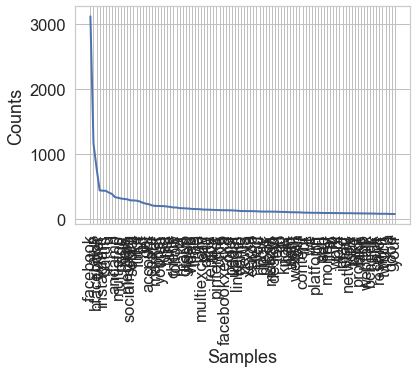

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
commonWords = nltk.FreqDist(tokens)
print("Most common words ")
print("Word\tCount")
for (word, count) in commonWords.most_common(100): # most common words across all texts
    print(word,"\t",count)

commonWords.plot(100, cumulative=False)

In [20]:
# #preprocessing if using list instead of a text file.
# totalAllCaps = 0

# text = [removeUnicode(tweet) for tweet in all_tweets]

# text = [replaceURL(tweet) for tweet in text]

# text = [replaceAtUser(tweet) for tweet in text]

# text = [removeHashtagInFrontOfWord(tweet) for tweet in text]

# text = [replaceContraction(tweet) for tweet in text]

# text = [removeNumbers(tweet) for tweet in text]

# text = [replaceMultiExclamationMark(tweet) for tweet in text]

# text = [replaceMultiQuestionMark(tweet) for tweet in text]

# text = [replaceMultiStopMark(tweet) for tweet in text]

# tokens = [tokenize(tweet) for tweet in text]

In [21]:
# Create counter
counts_no_urls = collections.Counter(tokens)

counts_no_urls.most_common(15)

[('facebook', 3125),
 ('atus', 1159),
 ('bfacebook', 784),
 ('twitter', 440),
 ('instagram', 434),
 ('batus', 433),
 ('u', 405),
 ('i', 384),
 ('andamp', 334),
 ('multistop', 325),
 ('page', 313),
 ('new', 307),
 ('medium', 301),
 ('socialmedia', 285),
 ('social', 284)]

In [22]:
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

,words,count
0,facebook,3125
1,atus,1159
2,bfacebook,784
3,twitter,440
4,instagram,434


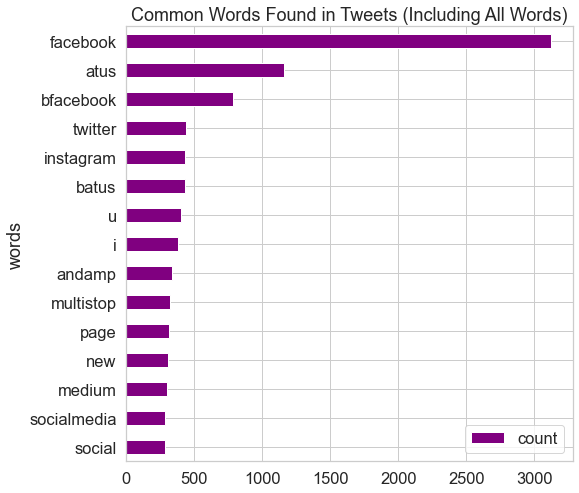

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()


In [24]:
collection_words = ['facebook', 'fb', 'bfacebook']

In [25]:
final_tokens = []
for word in tokens:
    if word not in collection_words:
        final_tokens.append(word)

In [26]:
# Create counter of words in clean tweets
counts_nsw_nc = collections.Counter(final_tokens)

counts_nsw_nc.most_common(15)

[('atus', 1159),
 ('twitter', 440),
 ('instagram', 434),
 ('batus', 433),
 ('u', 405),
 ('i', 384),
 ('andamp', 334),
 ('multistop', 325),
 ('page', 313),
 ('new', 307),
 ('medium', 301),
 ('socialmedia', 285),
 ('social', 284),
 ('like', 281),
 ('futur', 269)]

In [27]:
len(counts_nsw_nc)

10316

In [28]:
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(15),
                             columns=['words', 'count'])
clean_tweets_ncw.head()

,words,count
0,atus,1159
1,twitter,440
2,instagram,434
3,batus,433
4,u,405


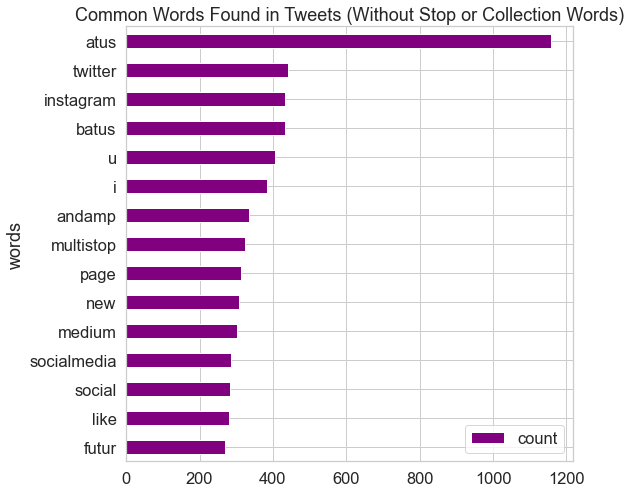

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop or Collection Words)")

plt.show()


In [30]:
# Create list of lists containing bigrams in tweets
from nltk import bigrams
terms_bigram = list(bigrams(final_tokens))

# View bigrams for the first tweet
terms_bigram[0]

('market', 'openingnnfbnfacebook')

In [31]:
# Create counter of words in clean bigrams
bigram_counts = collections.Counter(terms_bigram)

bigram_counts.most_common(20)

[(('atus', 'atus'), 278),
 (('social', 'medium'), 220),
 (('futur', 'futur'), 155),
 (('batus', 'atus'), 136),
 (('via', 'atus'), 103),
 (('twitter', 'instagram'), 101),
 (('check', 'websit'), 63),
 (('blinkedin', 'twitter'), 62),
 (('btwitter', 'instagram'), 60),
 (('socialmedia', 'pinterest'), 58),
 (('share', 'data'), 57),
 (('instagram', 'socialmedia'), 56),
 (('websit', 'top'), 52),
 (('fake', 'account'), 48),
 (('instagram', 'pinterest'), 47),
 (('quit', 'europ'), 45),
 (('for', 'inform'), 43),
 (('data', 'u'), 43),
 (('top', 'affili'), 41),
 (('may', 'quit'), 41)]

In [32]:
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(atus, atus)",278
1,"(social, medium)",220
2,"(futur, futur)",155
3,"(batus, atus)",136
4,"(via, atus)",103
5,"(twitter, instagram)",101
6,"(check, websit)",63
7,"(blinkedin, twitter)",62
8,"(btwitter, instagram)",60
9,"(socialmedia, pinterest)",58


In [33]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

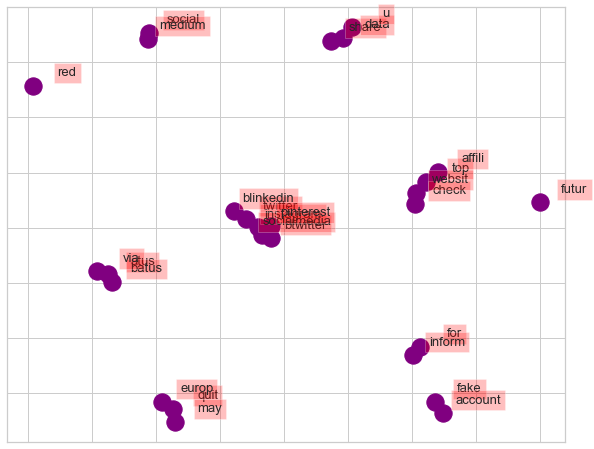

In [34]:
# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v*10))

G.add_node("red", weight=100)
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)
# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

# Sentiment Ananlysis

## Vader
##### VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.

In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [36]:
tweets = pd.read_csv('result.txt', header = None, sep = '\t')

In [37]:
tweets.rename({1:'Tweet'}, inplace = True, axis = 1)

In [38]:
tweets.drop(0, axis = 1, inplace = True)

In [39]:
tweets.dropna(inplace = True)

In [40]:
tweets['compound'] = tweets['Tweet'].apply(lambda x: analyser.polarity_scores(x)['compound'])

In [41]:
tweets

,Tweet,compound
0,facebook market open fb facebook,0.0000
1,how get endless lead facebook homebusi andgtandgt,0.0000
2,thi prompt start use twitter i like social med...,0.3612
3,rb launch global partner program to meet deman...,-0.1280
4,facebook trollfarm botarmi trumprussia bot lik...,0.8481
...,...,...
47948,ball_caps_baddict ad film facebook more togeth...,0.0000
47949,b key socialmedia market success facebook exec...,0.5719
47950,batus facebook market place,0.0000
47951,bif havenxcxt alreadi throw facebook page like...,0.3612


In [42]:
tweets['compound'].mean()

0.05834396562512552

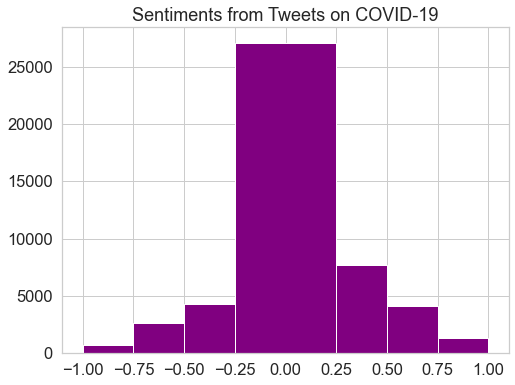

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
tweets.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on COVID-19")
plt.show()

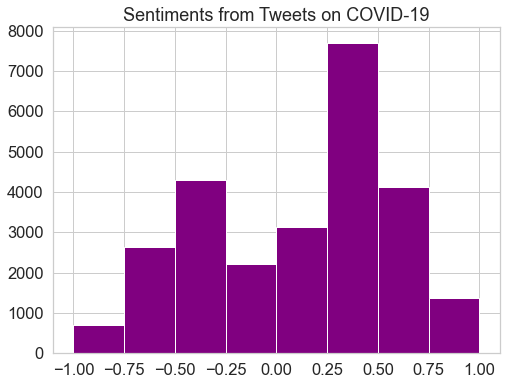

In [44]:
# Remove polarity values equal to zero
tweets = tweets[tweets.compound != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
tweets.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on COVID-19")
plt.show()

### Results

Here the total polarity of all the tweets is 0.06 which is neither too positive nor too negative.<br>
Further, we can find out what percentage of positive tweets were there and what percentage of negative tweets were there.<br>
It will help us understand for a particular time frame what type of tweets are more.

In [45]:
import numpy as np

In [46]:
tweets['Positive'] = np.where(tweets['compound'] >= 0.10, 1, 0)

C:\Users\yashc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
tweets['Positive'].sum()/len(tweets)

0.582190996219787

There are total 59.01% of positive tweets in the data for #facebook

In [48]:
tweets['Negative'] = np.where(tweets['compound'] <= -0.10, 1, 0)

C:\Users\yashc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
tweets['Negative'].sum()/len(tweets)

0.3645805490854939

There are a total of 35.6% of the negative tweets in the data for # Facebook.